In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_roc
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [2]:
pd.set_option('display.max_rows', 20)

In [2]:
df_train=pd.read_csv('Train_numeric_cat.csv', index_col=0)
df_test=pd.read_csv('Test_numeric_cat.csv', index_col=0)

In [3]:
df_train.drop(['modality', 'actor','repetition', 'filename'], axis=1, inplace=True)

df_test.drop(['modality', 'actor','repetition', 'filename'], axis=1, inplace=True)

In [4]:
vc_map= {'speech':0, 'song':1}
emo_int_map={'normal':0, 'strong':1}
state_map= {'Kids are talking by the door':0,'Dogs are sitting by the door':1}
sex_map={'M':0, 'F':1}
emo_map={'angry':0,'calm':1,'disgust':2, 'fearful':3, 'happy':4, 
'neutral': 5, 'sad':6, 'surprised':7  }

df_train.replace({'vocal_channel':vc_map,'emotional_intensity':emo_int_map,
'emotion':emo_map, 'statement':state_map,'sex':sex_map },inplace=True)



In [7]:
df_test.replace({'vocal_channel':vc_map,'emotional_intensity':emo_int_map,
'emotion':emo_map, 'statement':state_map,'sex':sex_map },inplace=True)

In [8]:
x_train=df_train.drop('emotion', axis=1)
x_test= df_test.drop('emotion', axis=1)
y_train= df_train['emotion']
y_test= df_test['emotion']

In [116]:
df_trial=pd.read_csv('RavdessAudioOnlyFeatures_TEST.csv')

In [119]:
y_test_label=df_trial['emotion']
y_test_label

0      neutral
1      neutral
2      neutral
3      neutral
4         calm
        ...   
619    fearful
620    fearful
621    fearful
622    fearful
623    fearful
Name: emotion, Length: 624, dtype: object

In [9]:
sc=StandardScaler()

x_train_norm=sc.fit_transform(x_train)
x_test_norm=sc.transform(x_test)

In [66]:
clf_base= LogisticRegression(max_iter=100000)
clf_base.fit(x_train_norm, y_train)
print(f'train acc: {accuracy_score(y_train, clf_base.predict(x_train_norm))}')
print(classification_report(y_test, clf_base.predict(x_test_norm)))

train acc: 0.6637020566981656
              precision    recall  f1-score   support

           0       0.60      0.80      0.68        96
           1       0.51      0.58      0.55        96
           2       0.40      0.52      0.45        48
           3       0.56      0.25      0.35        96
           4       0.38      0.47      0.42        96
           5       0.46      0.40      0.43        48
           6       0.38      0.21      0.27        96
           7       0.49      0.69      0.57        48

    accuracy                           0.48       624
   macro avg       0.47      0.49      0.46       624
weighted avg       0.48      0.48      0.46       624



In [52]:
clf_b=LogisticRegression(random_state=44, max_iter=10000, penalty= 'l1', solver='liblinear', C=0.1111)
clf_b.fit(x_train_norm, y_train)

%store clf_b

Stored 'clf_b' (LogisticRegression)


In [67]:
y_pred=clf_b.predict(x_test_norm)
print('Accuracy %s' % accuracy_score(y_train, clf_b.predict(x_train_norm)))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.594219010561423
F1-score [0.65873016 0.58373206 0.39215686 0.32592593 0.41414141 0.58139535
 0.35616438 0.58333333]
              precision    recall  f1-score   support

           0       0.53      0.86      0.66        96
           1       0.54      0.64      0.58        96
           2       0.37      0.42      0.39        48
           3       0.56      0.23      0.33        96
           4       0.40      0.43      0.41        96
           5       0.66      0.52      0.58        48
           6       0.52      0.27      0.36        96
           7       0.49      0.73      0.58        48

    accuracy                           0.50       624
   macro avg       0.51      0.51      0.49       624
weighted avg       0.51      0.50      0.48       624



In [245]:
print(accuracy_score(y_train, clf_b.predict(x_train_norm)))

0.594219010561423


In [57]:
c_scores=[]
Cs=np.linspace(0.05, 0.5, 50)

for c in Cs:
    clf=LogisticRegression(random_state=44, max_iter=10000, penalty= 'l1', solver='liblinear', C=c)
    scores=cross_val_score(clf, x_train_norm, y_train, cv=10)
    c_scores.append([c, np.mean(scores), np.std(scores)])

c_results = pd.DataFrame(c_scores, columns=['c','mean_Acc', 'std'])

In [63]:
c_results['mean_Acc'].max()

0.4991123525760397

<AxesSubplot:xlabel='c'>

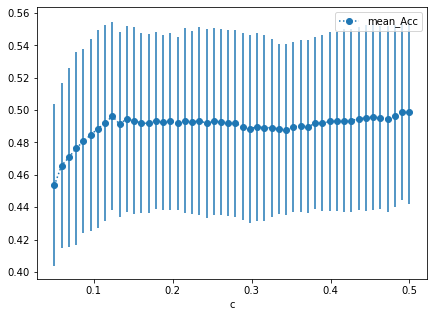

In [59]:
c_results.plot(x='c', y= 'mean_Acc', yerr='std',
marker='o', linestyle=':')

C is the inverse of the strenght of regularization. 

A high value of C tells the model to give high weight to the training data, and a lower weight to the complexity penalty. A low value tells the model to give more weight to this complexity penalty at the expense of fitting to the training data.
Balance between complexity and accuracy on training data. 

In [143]:
test_acc_l1= []
train_acc_l1=[]
coefs=np.linspace(0.01, 1, 50).tolist()

for c in coefs:
    clf=LogisticRegression(random_state=44 ,max_iter=1000000, penalty='l1', C=c, solver='liblinear')
    clf.fit(x_train_norm, y_train)
    tr=accuracy_score(y_train, clf.predict(x_train_norm))
    tst=accuracy_score(y_test, clf.predict(x_test_norm))
    train_acc_l1.append(tr)
    test_acc_l1.append(tst)

In [144]:
test_acc_l2= []
train_acc_l2=[]
coefs=np.linspace(0.01, 1, 50).tolist()

for c in coefs:
    clf=LogisticRegression(random_state=44 ,max_iter=1000000, penalty='l2', C=c)
    clf.fit(x_train_norm, y_train)
    tr=accuracy_score(y_train, clf.predict(x_train_norm))
    tst=accuracy_score(y_test, clf.predict(x_test_norm))
    train_acc_l2.append(tr)
    test_acc_l2.append(tst)

In [66]:
coefs.tolist()

[0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.0]

In [145]:

sns.reset_defaults()

In [146]:
plt.rcParams['figure.dpi']=200

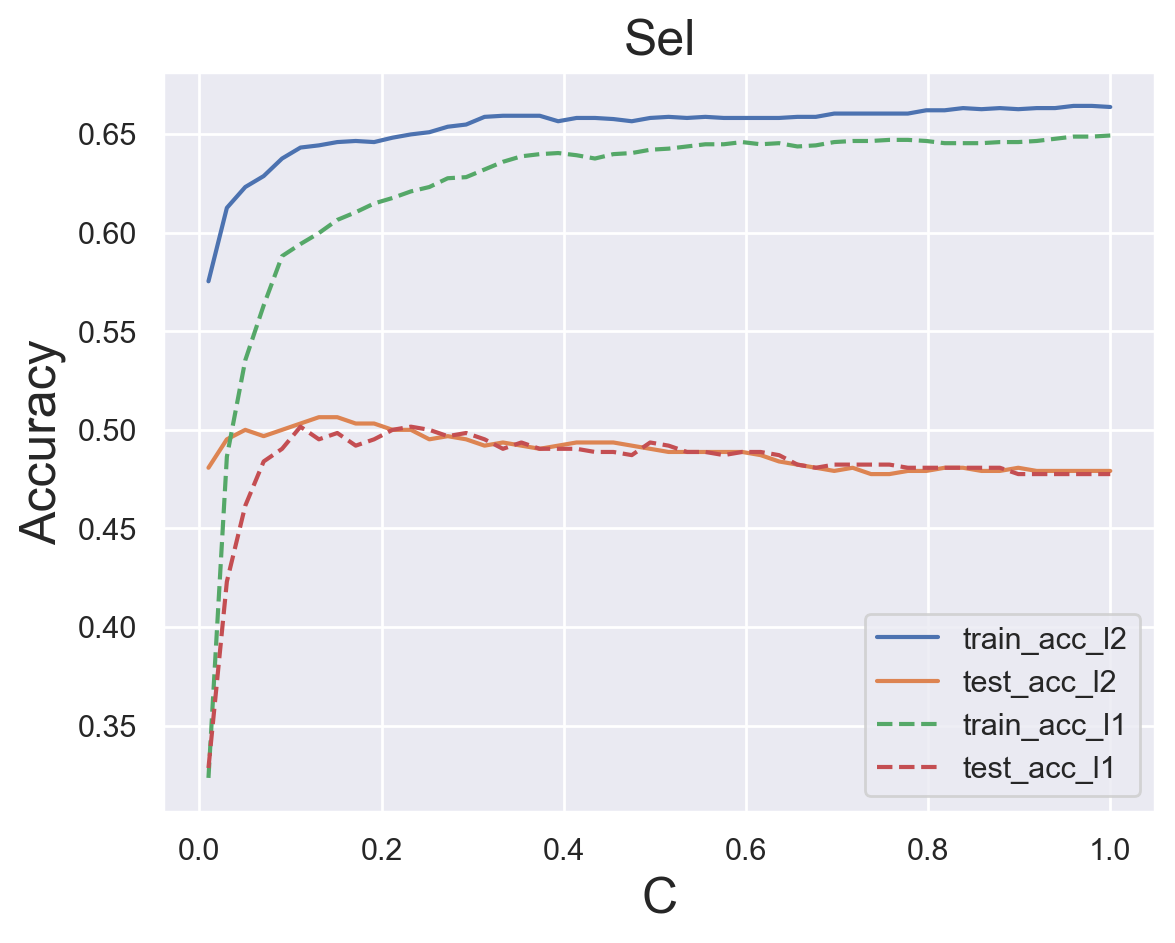

In [147]:
sns.set()
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.plot(coefs,train_acc_l2, label='train_acc_l2')
plt.plot(coefs, test_acc_l2, label='test_acc_l2')
plt.plot(coefs,train_acc_l1, label='train_acc_l1' , linestyle="--")
plt.plot(coefs, test_acc_l1, label='test_acc_l1', linestyle="--")
plt.xlabel('C', )
plt.ylabel('Accuracy')
plt.title('Sel')
plt.legend()

In [148]:
test_acc_l1= []
train_acc_l1=[]
coefs=np.linspace(0.01, 0.2, 50).tolist()

for c in coefs:
    clf=LogisticRegression(random_state=44 ,max_iter=1000000, penalty='l1', C=c, solver='liblinear')
    clf.fit(x_train_norm, y_train)
    tr=accuracy_score(y_train, clf.predict(x_train_norm))
    tst=accuracy_score(y_test, clf.predict(x_test_norm))
    train_acc_l1.append(tr)
    test_acc_l1.append(tst)

In [149]:
test_acc_l2= []
train_acc_l2=[]
coefs=np.linspace(0.01, 0.2, 50).tolist()

for c in coefs:
    clf=LogisticRegression(random_state=44 ,max_iter=1000000, penalty='l2', C=c)
    clf.fit(x_train_norm, y_train)
    tr=accuracy_score(y_train, clf.predict(x_train_norm))
    tst=accuracy_score(y_test, clf.predict(x_test_norm))
    train_acc_l2.append(tr)
    test_acc_l2.append(tst)

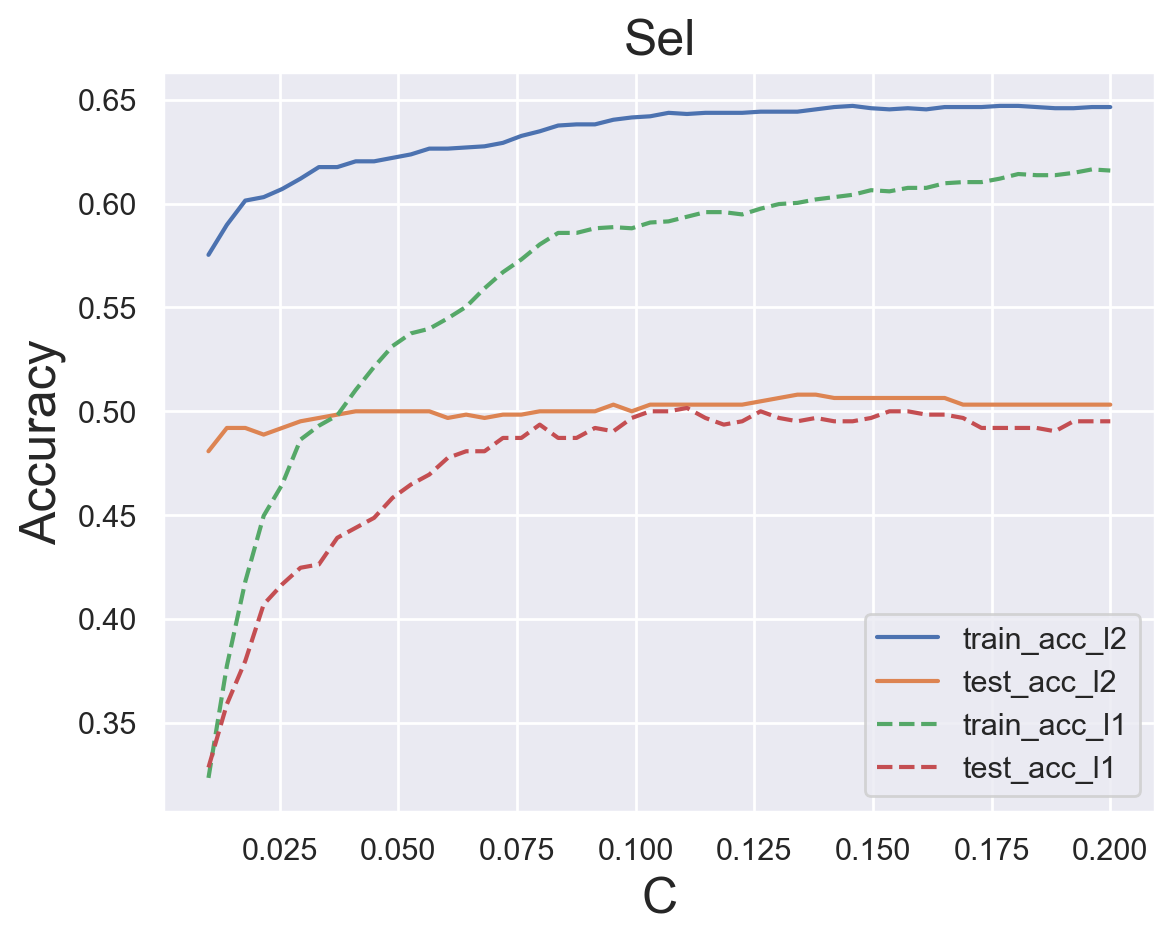

In [150]:
sns.set()

plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.plot(coefs,train_acc_l2, label='train_acc_l2')
plt.plot(coefs, test_acc_l2, label='test_acc_l2')
plt.plot(coefs,train_acc_l1, label='train_acc_l1', linestyle= "--")
plt.plot(coefs, test_acc_l1, label='test_acc_l1', linestyle="--")
plt.xlabel('C', )
plt.ylabel('Accuracy')
plt.title('Sel')
plt.legend()


In [49]:
def coefficients(model, target, data):
    
    emo_labels=['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

    if target=='all':

        d={'Attribute': data.columns, 
           'Coef_angry': model.coef_.tolist()[0],
           'Coef_calm': model.coef_.tolist()[1], 
           'Coef_disgust': model.coef_.tolist()[2],
           'Coef_fearful': model.coef_.tolist()[3],
           'Coef_happy': model.coef_.tolist()[4],
           'Coef_neutral': model.coef_.tolist()[5],
           'Coef_sad': model.coef_.tolist()[6],
           'Coef_surprised': model.coef_.tolist()[7]}
        interp=pd.DataFrame(data=d)
        return interp
    
    else:
        
        d={'Attribute': data.columns, 
           f'Coef_{emo_labels[target]}': model.coef_.tolist()[target]}
        interp=pd.DataFrame(data=d)
        
        return interp.sort_values(by=f'Coef_{emo_labels[target]}')

In [79]:
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.linspace(0.1, 0.2, 10),
    'solver' : ['liblinear']}

grid= GridSearchCV(
    LogisticRegression(random_state=44, max_iter=10000),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0, n_repeats=5),
    n_jobs=-1,
    refit=True)

grid.fit(x_train_norm, y_train)



GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=0),
             estimator=LogisticRegression(max_iter=10000, random_state=44),
             n_jobs=-1,
             param_grid={'C': array([0.1       , 0.11111111, 0.12222222, 0.13333333, 0.14444444,
       0.15555556, 0.16666667, 0.17777778, 0.18888889, 0.2       ]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [80]:
opt_log=grid.best_estimator_
print(grid.best_params_,grid.best_score_)

{'C': 0.2, 'penalty': 'l2', 'solver': 'liblinear'} 0.56398081089446


In [98]:
print(accuracy_score(y_test,opt_log.predict(x_test_norm)))
print(accuracy_score(y_train,opt_log.predict(x_train_norm)))

0.4855769230769231
0.6381322957198443


In [11]:
opt_log=LogisticRegression(C=0.2, penalty='l2', solver='liblinear')

In [12]:
%%timeit
opt_log.fit(x_train_norm, y_train)

384 ms ± 59.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
opt_clf=LogisticRegression(C=3.0621224489795917, max_iter=10000, penalty='l1',
                   random_state=44, solver='liblinear')

In [43]:
opt_clf.fit(x_train_norm, y_train)

y_pred_opt=opt_clf.predict(x_test_norm)
print(accuracy_score(y_test, y_pred_opt))


0.4791666666666667


In [46]:
accuracy_score(y_train, opt_clf.predict(x_train_norm))

0.651473040578099

ok so with strong regularization a good result was reached, train --> 0.59 | test --> 0.5 (this was luck, use opt_log). 
I think we can stop here because if we decrease the number of feature the initial overfitting without regurlarization will be smaller but all accuracies will be scaled down. 

While both metrics are essential, ROC AUC is generally seen as a more important measure of how good an algorithm is. This metric considers the trade-offs between precision and recall, while Accuracy only looks at how many predictions are correct.

Overall accuracy is based on one specific cutpoint, while ROC tries all of the cutpoint and plots the sensitivity and specificity. So when we compare the overall accuracy, we are comparing the accuracy based on some cutpoint. The overall accuracy varies from different cutpoint.

AUC is a measure of separability, tells us how capable is the model in classifying a randomly selected point. 

In [14]:
opt_log.fit(x_train_norm, y_train)

LogisticRegression(C=0.2, solver='liblinear')

In [19]:
print(classification_report(y_test, opt_log.predict(x_test_norm)))

              precision    recall  f1-score   support

           0       0.57      0.81      0.67        96
           1       0.52      0.61      0.56        96
           2       0.39      0.56      0.46        48
           3       0.62      0.26      0.37        96
           4       0.38      0.44      0.40        96
           5       0.54      0.44      0.48        48
           6       0.42      0.19      0.26        96
           7       0.49      0.69      0.57        48

    accuracy                           0.49       624
   macro avg       0.49      0.50      0.47       624
weighted avg       0.49      0.49      0.46       624



In [154]:
sns.reset_defaults()

In [156]:
plt.rcParams['figure.dpi']=200

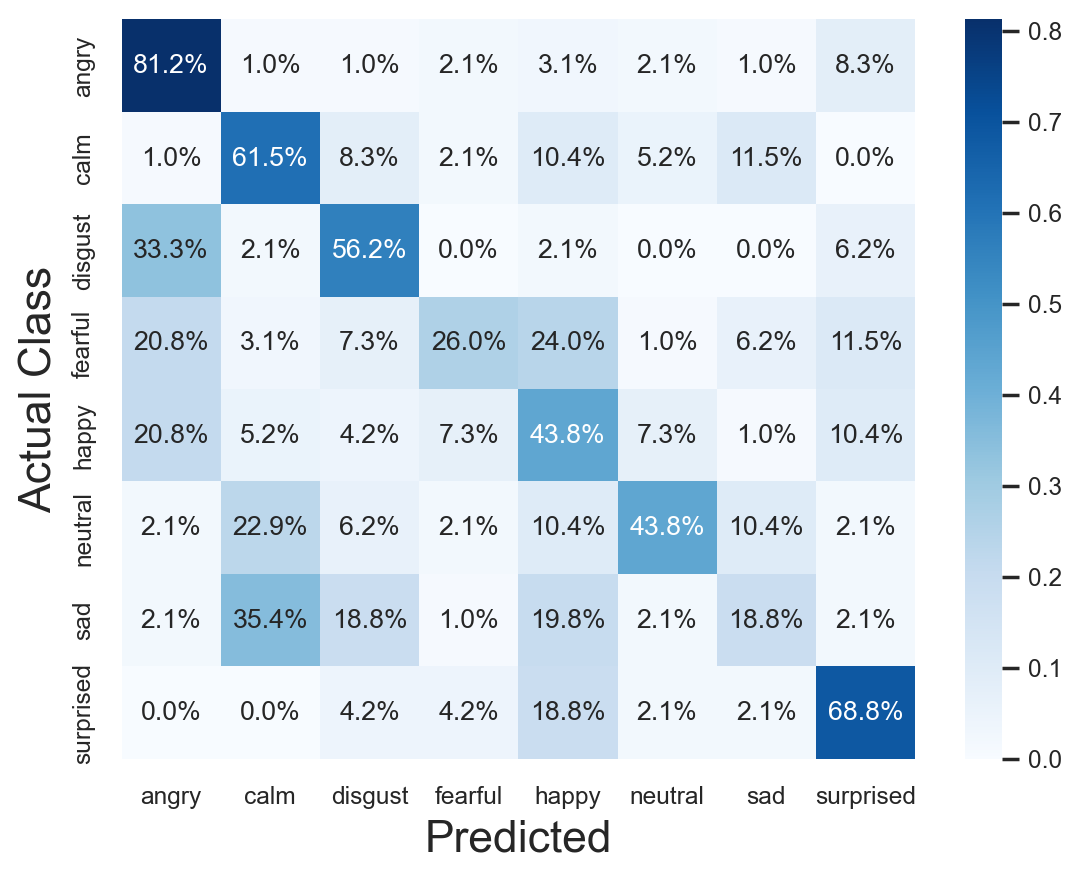

In [157]:

emo_labels=['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
sns.set(font_scale=0.8)
conf_m= confusion_matrix(y_test, opt_log.predict(x_test_norm), normalize='true')
sns.heatmap(conf_m, annot=True, xticklabels=emo_labels, yticklabels=emo_labels, fmt='.1%',cmap='Blues' )
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("Actual Class", fontsize=16)
plt.show()

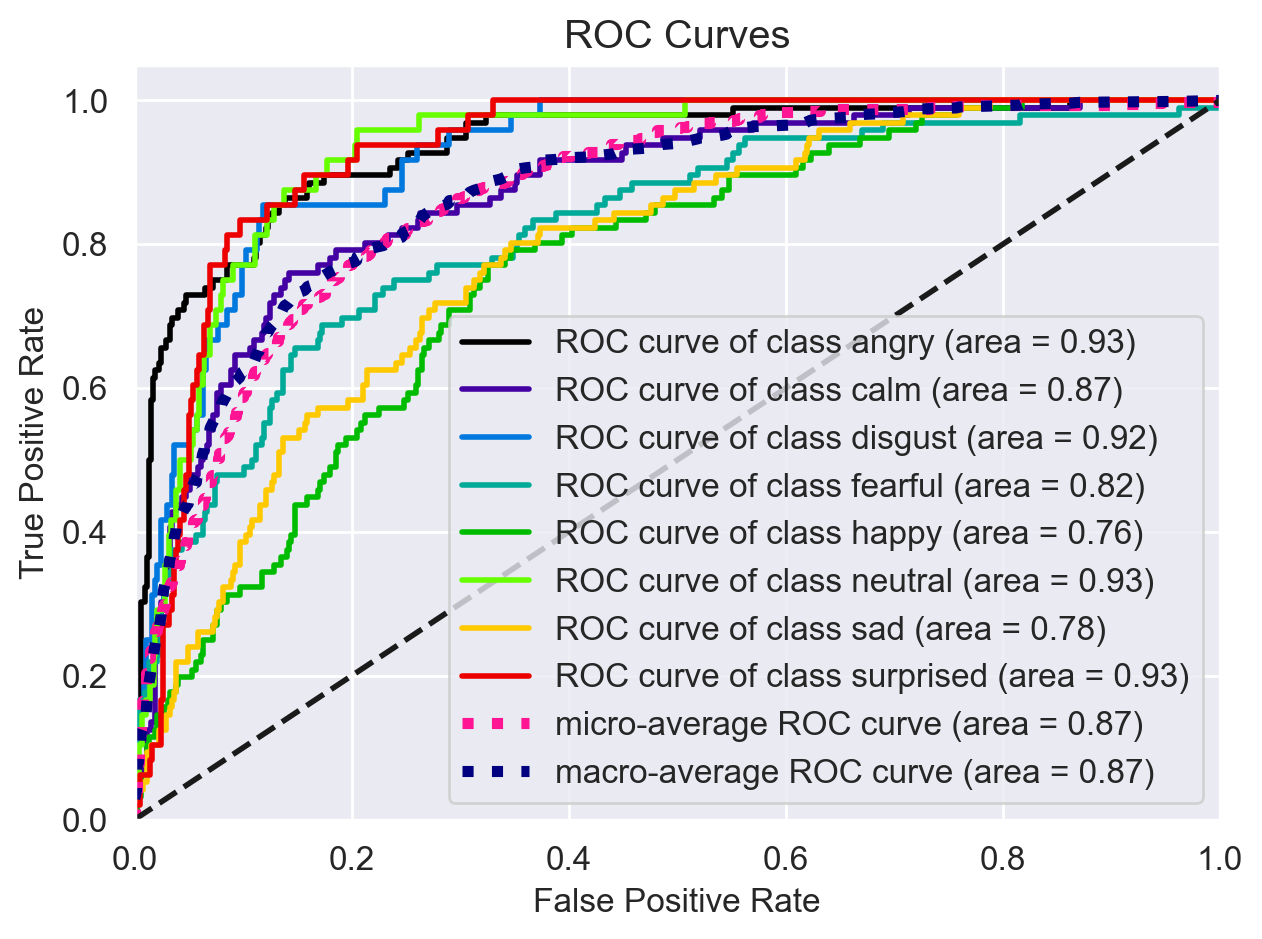

In [120]:
plt.rcParams["figure.figsize"] = (7,5)

plot_roc(y_test_label, opt_log.predict_proba(x_test_norm))
plt.show()


In [20]:
def youndenJ(y_true, data, positive_label, model):
    tpr, fpr, thresholds = roc_curve(y_true, model.predict(data), pos_label=positive_label)
    J= tpr - fpr
    best_J= max(J)
    best_threshold = thresholds[np.argmax(J)]

    return best_J, best_threshold

In [37]:
best_J, best_threshold= youndenJ(y_test, x_test_norm, 7, opt_log)
best_J

0.0

In [79]:

df_coef=coefficients(opt_log, 7, x_train)
df_coef

,Attribute,Coef_surprised
39,mfcc_q25_w3,-1.202864
47,stft_kur_w3,-0.571655
26,sc_q05_w2,-0.368196
46,stft_sum_w3,-0.332627
42,sc_min_w3,-0.323364
...,...,...
16,sc_std_w1,0.396426
41,sc_std_w3,0.507923
11,stft_sum,0.508785
27,sc_q25_w2,0.588047


it might be interesting to analyze coefficents in the following way:
- look for best 3 in absolute value for each emotion 
- do this for both whole and sel
- look for collinearity pros and cons, i.e.:
    - collinearity is bad because increases the variance of estimators. Multicollinearity does not reduce the predictive power or reliability of the model as a whole, at least within the sample data set; it only affects calculations regarding individual predictors. 
    That is, a multivariable regression model with collinear predictors can indicate how well the entire bundle of predictors predicts the outcome variable, but it may not give valid results about any individual predictor, or about which predictors are redundant with respect to others. --> try VIF. VIF tells us how much an attribute can be linearly predicted by the others. High vif means the attribute is redundant, so can be discarded.

    - ok, features with high vif were eliminated, but know the model sucks (0.32 test accuracy). This is normal sice we have fewer attributes, but now have better estimates (in theory) for the coefficients. 
    At this point it may be interesting to look at how the best three coefs have changed. 

In [ ]:
pd.set_option('display.max_rows', None)
x_train.corr().style.background_gradient(cmap='coolwarm')

In [41]:
def getVifs(data):

    vifs=[]

    for i in range (len(data.columns)):
        vif= variance_inflation_factor(data.values, i)
        vifs.append(vif)

    vif_data_dict={'feature':data.columns, 'vif': vifs}
    vif_data=pd.DataFrame(data=vif_data_dict)
    return vif_data


In [44]:
x_train_vif=x_train.copy()
discarded=[] #discarded features


vif_data=getVifs(x_train_vif) #first dataset with vif for each feature 

max_vif= vif_data['vif'].max()

while max_vif >= 10: #want the max vif to be 5
    
    worst_feat=vif_data['feature'][vif_data['vif']==max_vif].values[0] # worst feature (highest vif) for current dataset
    x_train_vif.drop(worst_feat, axis=1, inplace=True)
    discarded.append(worst_feat)
    vif_data = getVifs(x_train_vif)
    max_vif= vif_data['vif'].max()

vif_data
    




,feature,vif
0,vocal_channel,5.038291
1,emotional_intensity,2.130944
2,statement,3.510329
3,sex,3.778466
4,lag1_kur,3.575796
5,kur_w1,2.644327
6,lag1_kur_w1,2.746476
7,mfcc_q99_w1,5.181887
8,sc_std_w1,5.969603
9,kur_w2,4.681168


In [200]:
pd.set_option('display.max_rows', 10)
x_train_vif

,vocal_channel,emotional_intensity,statement,sex,lag1_kur,kur_w1,lag1_kur_w1,kur_w2,sc_kur_w2,kur_w3,lag1_skew_w3,stft_kur_w3,kur_w4,lag1_kur_w4,lag1_skew_w4,sc_min_w4,sc_skew_w4,stft_kur_w4
1,0,0,0,0,42.127435,3204.243867,1947.694789,6.497608,-1.166039,2.179153,1.111501,-0.901135,33.514234,9.338330,-0.019713,6469.028326,-1.100390,-0.700420
2,0,0,1,0,54.529269,12.082855,6.991660,5.434203,-1.067715,2.424088,0.687577,-0.872227,19.702873,10.651796,-0.007310,0.000000,-3.120218,1.688986
3,0,0,1,0,53.008445,16.790632,9.815491,6.784152,-1.157516,2.406170,0.902201,-1.001521,18.295975,5.190977,0.001556,6527.892850,-0.880988,-0.594111
4,0,0,0,0,44.373537,3085.072283,3285.379445,6.904386,-0.506268,2.256041,1.466636,-0.826211,18.503776,5.089207,0.003186,5424.476334,-1.071109,0.126535
5,0,0,0,0,43.496743,233.996847,291.213116,7.012648,0.448760,2.189301,1.344708,-0.886686,41.434696,12.249078,-0.067202,0.000000,-1.512306,1.823902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,0,0,1,1,41.185338,34.307701,22.684818,2.264550,-1.514176,1.330361,0.908492,-0.564805,75.181547,23.947394,0.034310,0.000000,-1.472070,0.262900
1824,0,1,0,1,65.761796,36.435595,13.070595,2.541186,0.362575,3.355073,0.097067,-0.811637,24.924416,12.347995,-0.140572,0.000000,-1.301303,-0.857759
1825,0,1,0,1,57.209661,671.278243,301.333297,2.099794,-0.380133,0.830923,0.372091,-0.683728,31.760108,12.007039,0.017217,0.000000,-1.472613,-0.656632
1826,0,1,1,1,35.742894,399.794354,955.423895,0.378909,-1.430210,1.070370,0.313150,-0.534711,115.415790,80.076258,0.374166,0.000000,-1.160818,-0.499022


In [45]:
x_test_vif=x_test[x_train_vif.columns]

In [46]:
clf_vif=LogisticRegression(max_iter=100000000000)
clf_vif.fit(x_train_vif, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(max_iter=100000000000)

In [70]:
print(accuracy_score(y_train, clf_vif.predict(x_train_vif)))
print(classification_report(y_test, clf_vif.predict(x_test_vif)))

0.3852140077821012
              precision    recall  f1-score   support

           0       0.40      0.68      0.50        96
           1       0.40      0.35      0.38        96
           2       0.23      0.17      0.19        48
           3       0.31      0.25      0.28        96
           4       0.26      0.32      0.29        96
           5       0.29      0.25      0.27        48
           6       0.25      0.17      0.20        96
           7       0.22      0.17      0.19        48

    accuracy                           0.32       624
   macro avg       0.29      0.29      0.29       624
weighted avg       0.30      0.32      0.30       624



In [129]:
coefficients(clf_vif,'all',x_test_vif)

,Attribute,Coef_angry,Coef_calm,Coef_disgust,Coef_fearful,Coef_happy,Coef_neutral,Coef_sad,Coef_surprised
0,vocal_channel,0.396822,-0.087476,-0.438554,0.267970,-0.034030,0.171673,0.062223,-0.338628
1,emotional_intensity,-0.278160,0.412355,0.066143,-0.000491,-0.004572,-0.669471,0.240429,0.233768
2,statement,0.221484,0.110601,-0.117444,-0.043488,0.075131,0.076076,-0.059219,-0.263142
3,sex,0.144493,-0.051898,0.015070,0.266268,-0.077826,-0.134088,-0.100797,-0.061222
4,lag1_kur,-0.022363,0.013103,0.001398,0.010443,-0.020948,0.005643,0.012852,-0.000129
5,kur_w1,-0.000269,0.000281,0.000204,-0.000153,0.000007,0.000099,0.000073,-0.000243
6,lag1_kur_w1,0.000377,0.000201,0.000085,-0.000929,0.000331,0.000099,-0.000124,-0.000041
7,mfcc_q99_w1,0.000884,0.008646,-0.004352,0.007990,0.005259,-0.013646,0.004992,-0.009774
8,sc_std_w1,-0.000027,0.000138,0.000042,-0.000089,-0.000038,-0.000117,0.000030,0.000060
9,kur_w2,0.163330,-0.099042,0.038026,0.005393,0.032812,-0.050265,-0.039865,-0.050389
